# Pneumonia Classifier

### Import Essential Libraries and Frameworks

In [56]:
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.image import per_image_standardization
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix


### Define paths


In [3]:
train_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
train_pneu_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

test_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/'
test_pneu_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

val_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/'
val_pneu_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'

# find all files, that has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')

### Organizing and Preparing Training, Testing, and Validation Data Sets

In [4]:
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])

for x in train_pneu_cases:
    train_list.append([x, 1])

for x in test_normal_cases:
    test_list.append([x, 0])

for x in test_pneu_cases:
    test_list.append([x, 1])

for x in val_normal_cases:
    val_list.append([x, 0])

for x in val_pneu_cases:
    val_list.append([x, 1])

# shuffle data
random.shuffle(train_list)
random.shuffle(test_list)
random.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

### Show what does "train" dataframe contain

In [5]:
train_df

,image,label
0,drive/MyDrive/Pneumonia2/data/train/NORMAL/NOR...,0
1,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1
2,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1
3,drive/MyDrive/Pneumonia2/data/train/NORMAL/IM-...,0
4,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1
...,...,...
5942,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1
5943,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1
5944,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1
5945,drive/MyDrive/Pneumonia2/data/train/PNEUMONIA/...,1


### Data Split Proportion Visualization with Pie Chart

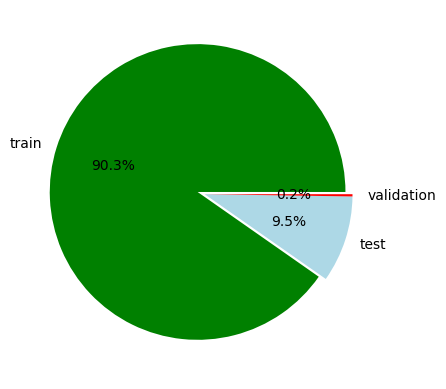

In [7]:
plt.pie( [len(train_df), len(test_df), len(val_df)],
        labels = ["train", "test", "validation"], colors = ["green", "lightblue", "red"], autopct='%1.0001f%%', explode = (0.05, 0, 0))
plt.show()

### Displaying Sample Images

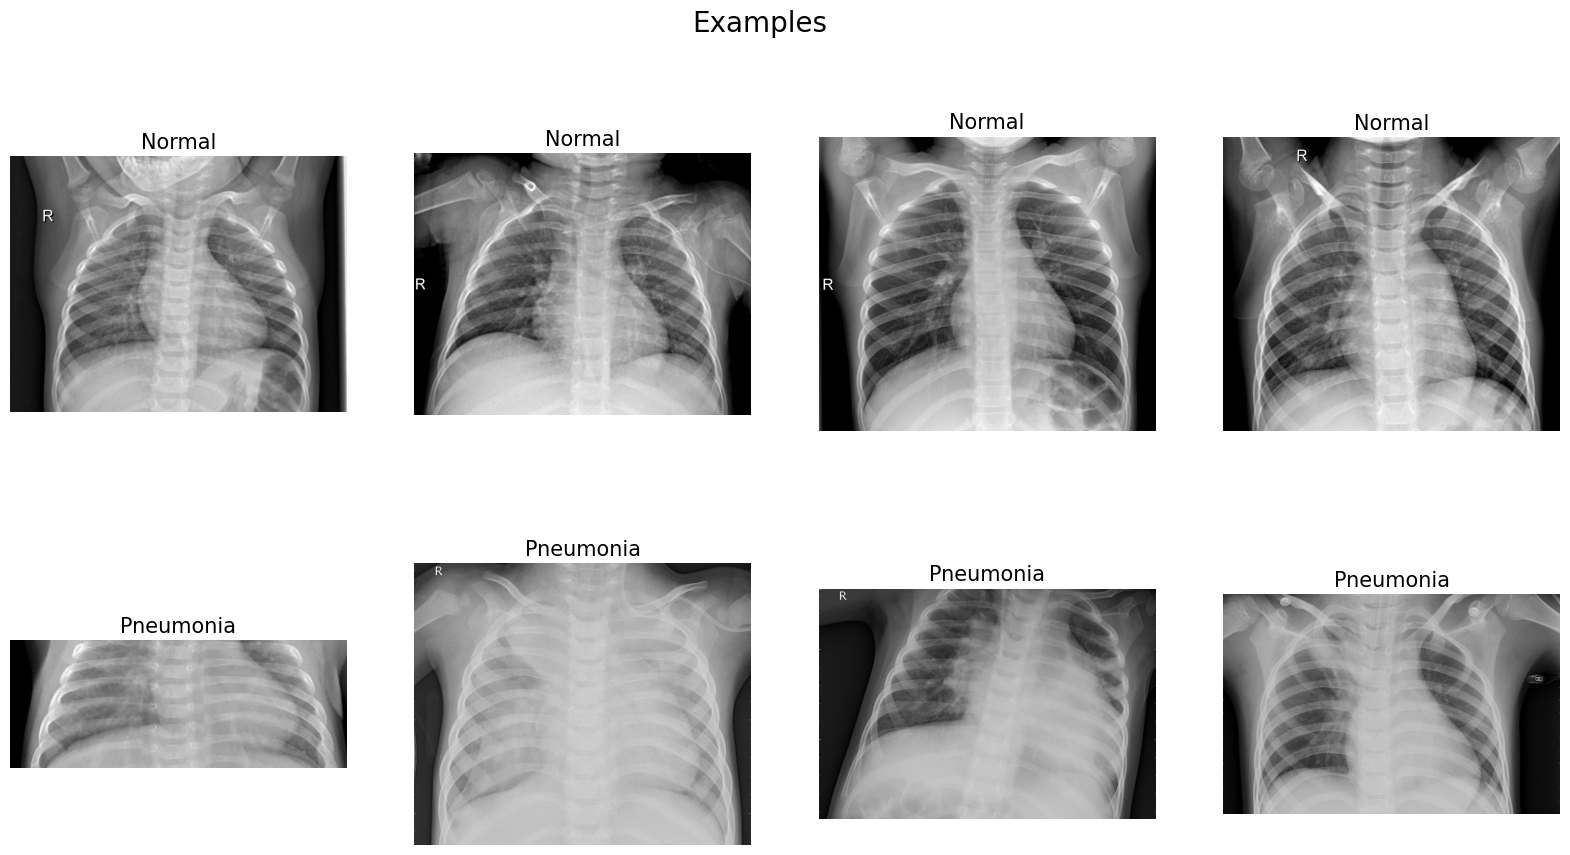

In [8]:
def plot_sample_images(df, title):
    plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=20)

    # Random indexes of images
    normal_images = df[df['label'] == 0].sample(4)
    pneumonia_images = df[df['label'] == 1].sample(4)

    # Show normal images
    for i, (index, row) in enumerate(normal_images.iterrows(), 1):
        plt.subplot(2, 4, i)
        img = mpimg.imread(row['image'])
        plt.imshow(img, cmap='gray')
        plt.title('Normal', fontsize=15)
        plt.axis('off')

    # Show pneumonia images
    for i, (index, row) in enumerate(pneumonia_images.iterrows(), 5):
        plt.subplot(2, 4, i)
        img = mpimg.imread(row['image'])
        plt.imshow(img, cmap='gray')
        plt.title('Pneumonia', fontsize=15)
        plt.axis('off')

    plt.show()


plot_sample_images(train_df, 'Examples')

### Image Preprocessing and Dataset Construction

In [9]:
def process_data(img_path):
  img = cv2.imread(img_path)
  resized_image = cv2.resize(img, (224, 224))
  image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY )
  image = image / 255.0
  img = np.reshape(image, (224,224,1))
  return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
      data.append(process_data(img_path))
      labels.append(label)

    return np.array(data), np.array(labels)

In [11]:
x_train, y_train = compose_dataset(train_df)
x_test, y_test = compose_dataset(test_df)
x_val, y_val = compose_dataset(val_df)

In [12]:
print("Train Data Size: {}, Labels Size: {}".format(x_train.shape, y_train.shape))
print("Test Data Size: {}, Labels Size: {}".format(x_test.shape, y_test.shape))
print("Validation Data Size: {}, Labels Size: {}".format(x_val.shape, y_val.shape))

Train Data Size: (5947, 224, 224, 1), Labels Size: (5947,)
Test Data Size: (624, 224, 224, 1), Labels Size: (624,)
Validation Data Size: (16, 224, 224, 1), Labels Size: (16,)


### Setting Up Image Data Augmentation

In [13]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1
)

datagen.fit(x_train)

### Defining a Sequential Model

In [14]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [15]:
optimizer = Adam(learning_rate = 0.0001, weight_decay = 1e-5)
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ["accuracy"])

In [16]:
history = model.fit(datagen.flow(x_train, y_train), epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
186/186 [==============================] - 800s 4s/step - loss: 0.4142 - accuracy: 0.8142 - val_loss: 0.4321 - val_accuracy: 0.8285
Epoch 2/10
186/186 [==============================] - 796s 4s/step - loss: 0.2389 - accuracy: 0.9073 - val_loss: 0.3131 - val_accuracy: 0.8734
Epoch 3/10
186/186 [==============================] - 780s 4s/step - loss: 0.2269 - accuracy: 0.9121 - val_loss: 0.3073 - val_accuracy: 0.8686
Epoch 4/10
186/186 [==============================] - 800s 4s/step - loss: 0.2071 - accuracy: 0.9173 - val_loss: 0.2816 - val_accuracy: 0.8766
Epoch 5/10
186/186 [==============================] - 796s 4s/step - loss: 0.1884 - accuracy: 0.9290 - val_loss: 0.3763 - val_accuracy: 0.8590
Epoch 6/10
186/186 [==============================] - 742s 4s/step - loss: 0.1897 - accuracy: 0.9284 - val_loss: 0.3233 - val_accuracy: 0.8766
Epoch 7/10
186/186 [==============================] - 787s 4s/step - loss: 0.1820 - accuracy: 0.9307 - val_loss: 0.3260 - val_accuracy: 0.8702

### Visualizing Training and Validation Accuracy

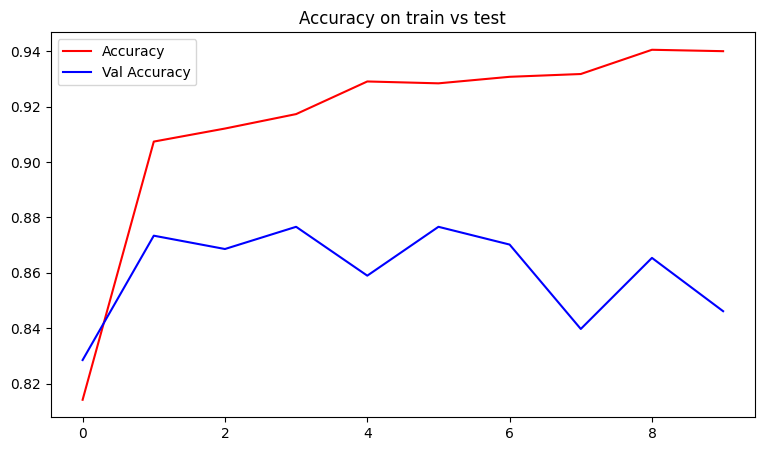

In [23]:
plt.figure(figsize=(20,5))

# Plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='red', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='blue', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [26]:
model.save("model")

### Predict function

In [38]:
def predict(image_path):
    img = load_img(image_path, target_size=(224, 224), color_mode="grayscale")
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return int(prediction[0][0] > 0.5)

### Displaying Samples with Predicted Labels

In [47]:
def plot_sample_images_with_predictions(df, title):
    plt.figure(figsize=(25, 24))
    plt.suptitle(title, fontsize=20)

    # 20 random images from df
    sample_images = df.sample(20)

    for i, (index, row) in enumerate(sample_images.iterrows(), 1):
        plt.subplot(4, 5, i)
        img = mpimg.imread(row['image'])
        plt.imshow(img, cmap='gray')

        # Getting originals and predicted labels
        original_label = 'Normal' if row['label'] == 0 else 'Pneumonia'
        predicted_label = 'Normal' if predict(row['image']) == 0 else 'Pneumonia'

        plt.title(f'{original_label} | {predicted_label}', fontsize=15)
        plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 58ms/step


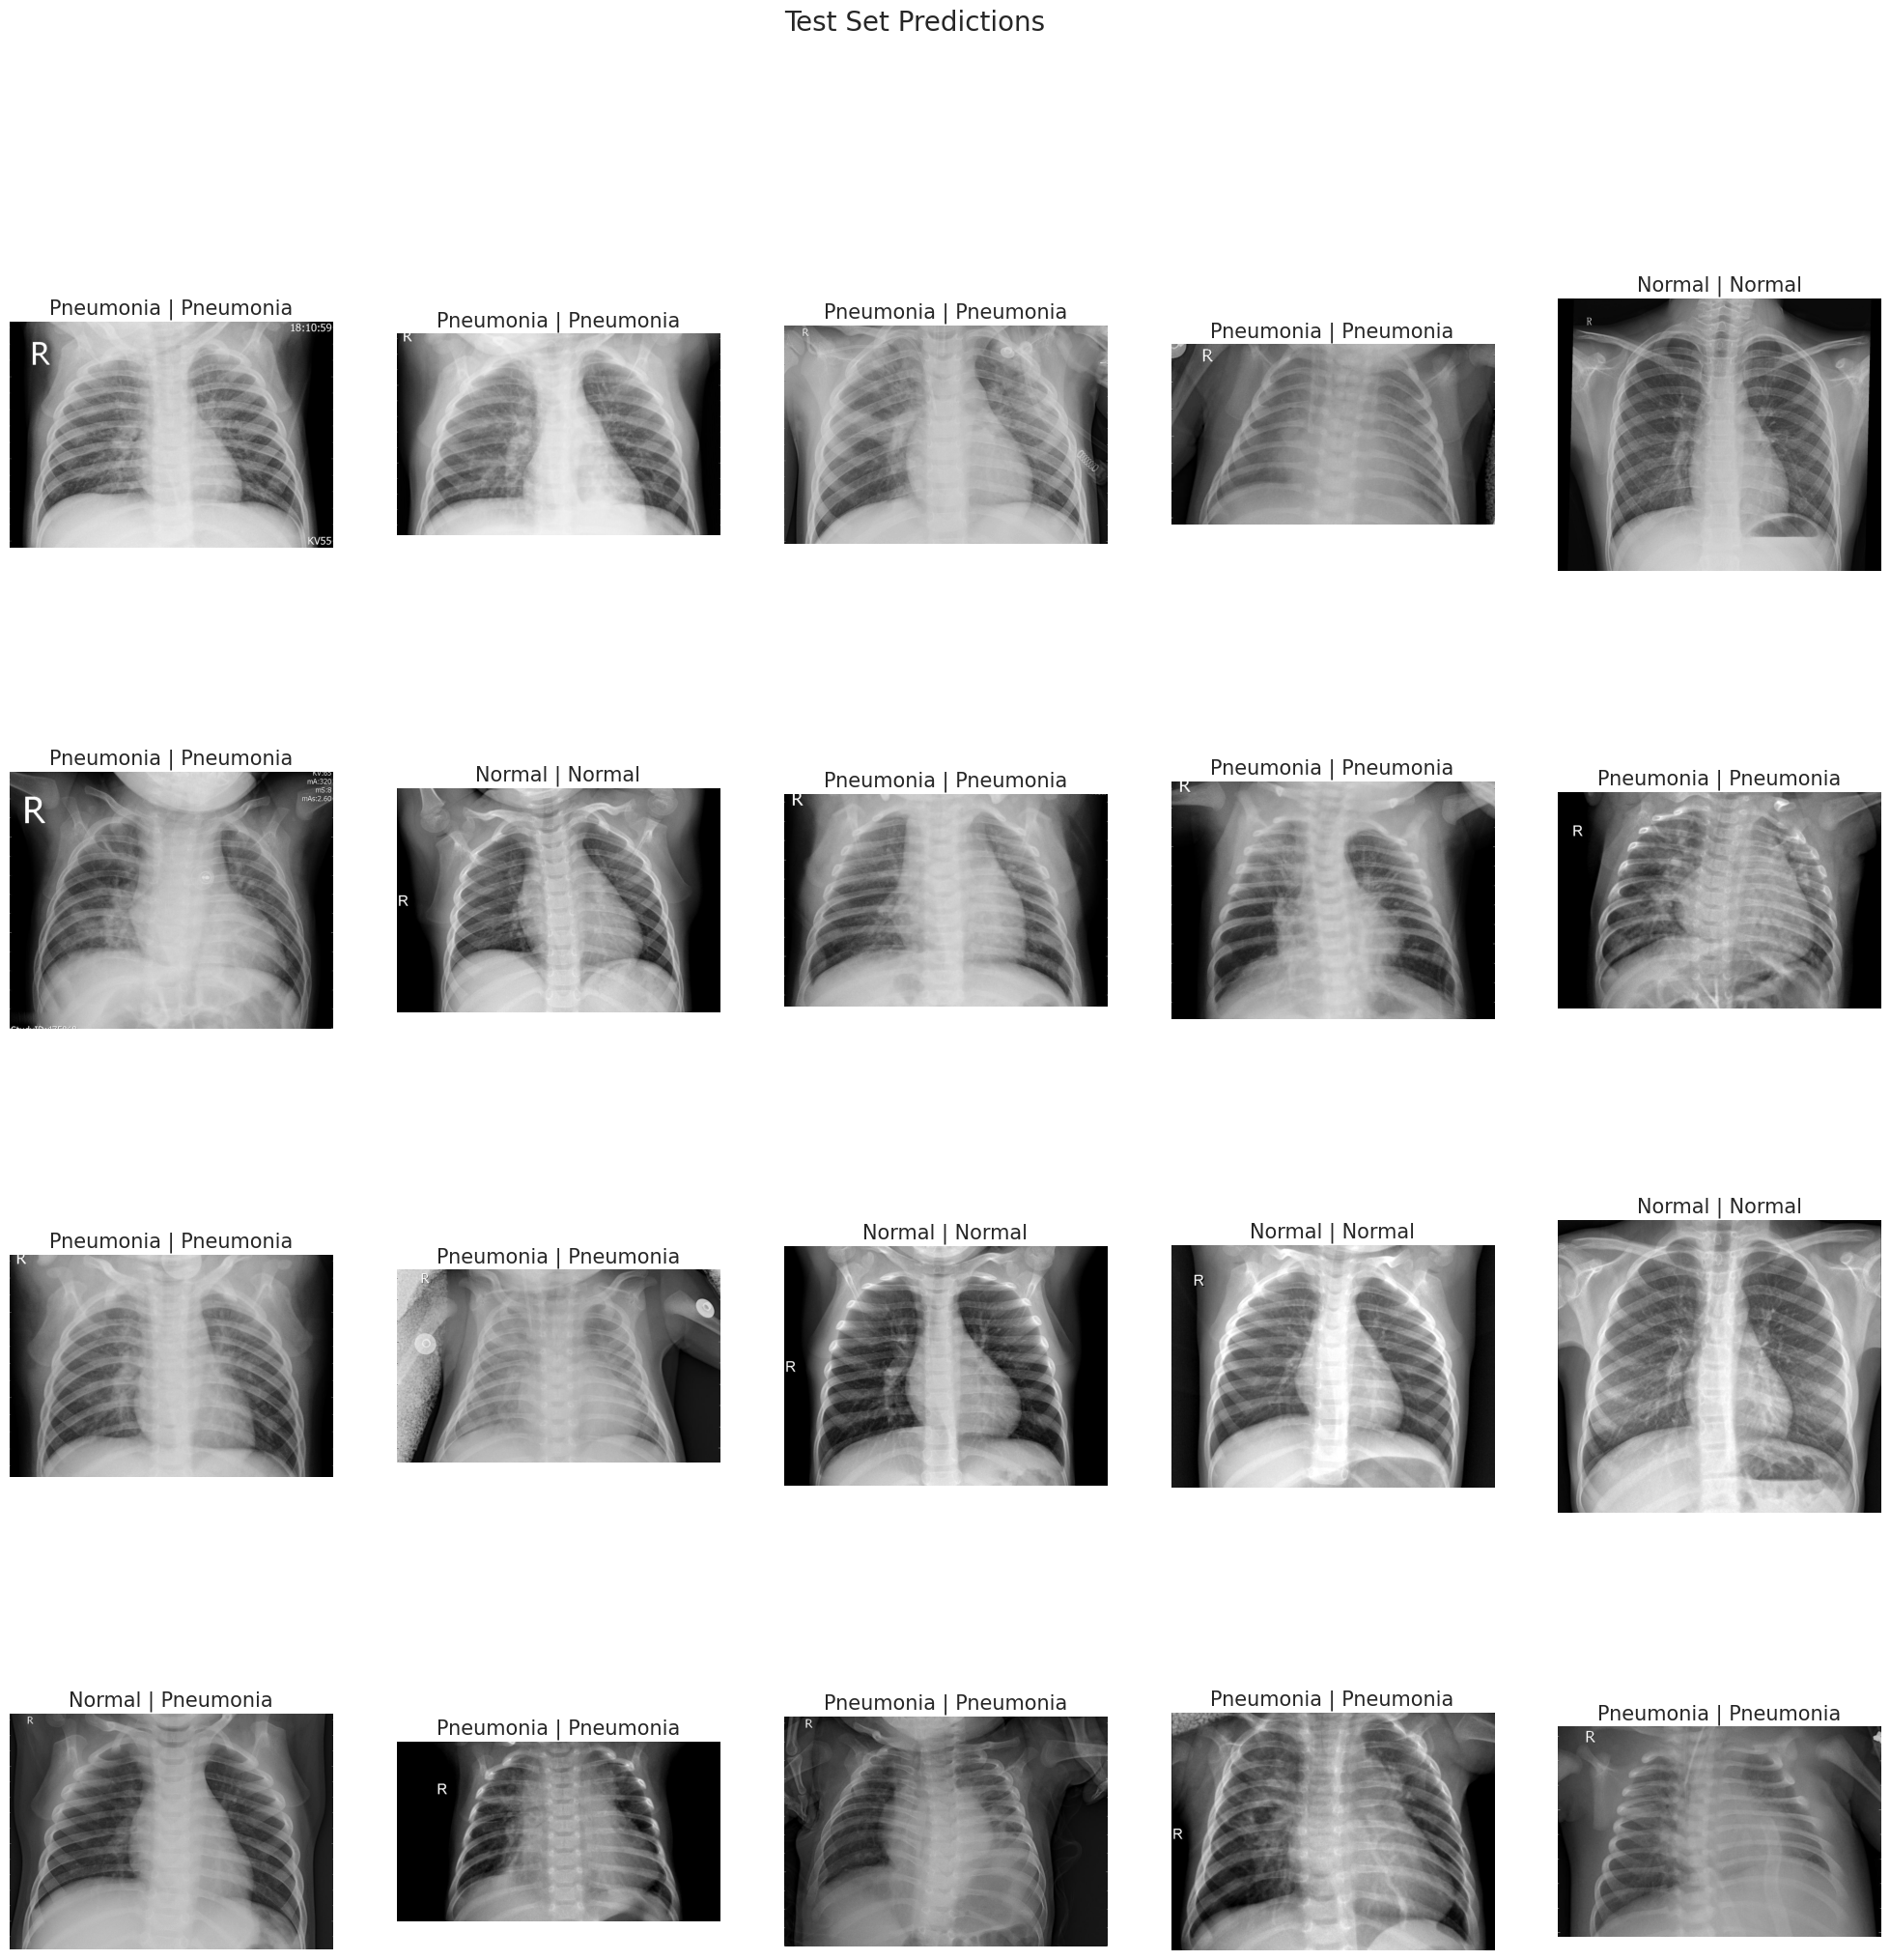

In [58]:
plot_sample_images_with_predictions(test_df, 'Test Set Predictions')

### Confusion Matrix and Classification Report

20/20 [==============================] - 26s 1s/step


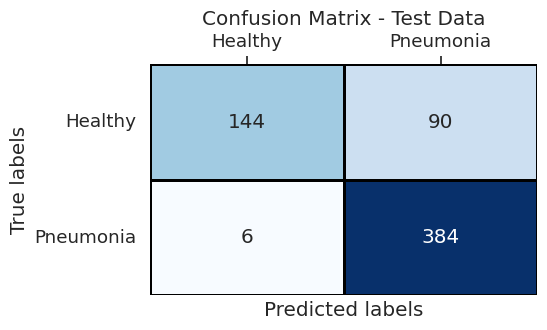

Classification report on test data
              precision    recall  f1-score   support

     Healthy       0.96      0.62      0.75       234
   Pneumonia       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



In [52]:
y_test_hat = model.predict(x_test)
y_test_hat = np.round(y_test_hat).astype(int)  # Possibility into 0 or 1

# Calculation of confusion matrix and classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat, target_names=['Healthy', 'Pneumonia'])

# Confusion matrix visualisation
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True, xticklabels=['Healthy', 'Pneumonia'], yticklabels=['Healthy', 'Pneumonia'], cbar=False, cmap='Blues', linewidths=1, linecolor='black', fmt='d')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top')
plt.title('Confusion Matrix - Test Data')
plt.show()

# Output of classification report
print('Classification report on test data')
print(clas_r)